## Parameter estimation with discovery and Eryn

Eryn is a powerful MCMC sampler that implements parallel tempering, reversible jump sampling and other advanced techniques. 
The `DiscoveryErynBridge` class provides an interface between discovery and Eryn, allowing you to easily set up and run MCMC sampling on a discovery model. 

Note that currently, the interface only supports fixed-dimension (i.e., non-reversible-jump) sampling. I'm working on adding that functionality in the near future.

Obviously, you need to have Eryn installed to use this interface, however all the actual Eryn sampler code is encapsulated in the `DiscoveryErynBridge` class, so you don't need to interact with Eryn directly.

This notebook demonstrates parameter estimation for pulsar timing data using the Discovery and Eryn libraries. It covers loading pulsar data, constructing likelihood models, defining priors, and running MCMC sampling with parallel tempering. Visualization of sampling results is provided through trace and corner plots. The workflow is modular and can be adapted for different pulsar datasets and model configurations.

In [ ]:
import discovery as ds
import glob

from discoverysamplers.eryn_interface import DiscoveryErynBridge

Let's get started by importing some (NanoGrav) pulsars and building a toy likelihood model. In our example we build a simple model with 3 pulsars, each with a power-law red noise process, giving us a total of 6 parameters to sample over (2 per pulsar). We fix the other parameters for simplicity.

In [6]:
import os

# Load pulsars from discovery by finding it's location
discovery_location = os.path.dirname(ds.__file__)

print("Found discovery package at:", discovery_location)

allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob(f'{discovery_location}/../../data/*-[JB]*.feather'))]

print(f"Loaded {len(allpsrs)} pulsars from feather files.")

psrs = allpsrs[:3]

print("Building likelihood for 3 pulsars...")

m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                        ds.makenoise_measurement(psr, psr.noisedict),
                                        ds.makegp_ecorr(psr, psr.noisedict),
                                        ds.makegp_timing(psr, svd=True),
                                        ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])
                for psr in psrs])
print("...done.")

Found discovery package at: /Users/jeg/Documents/discovery/discovery/src/discovery
Loaded 67 pulsars from feather files.
Building likelihood for 3 pulsars...
...done.


Let's print the parameters of the pulsars we loaded:

In [7]:

m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A']

To make our plots look nice, we can also add some LaTex labels to the parameters (this is optional):

In [8]:
# Make Latex labels for parameters
latex_labels = {}
for param in m.logL.params:
    if 'log10_A' in param:
        pulsar_name = param.split('_rednoise_')[0]
        latex_labels[param] = r"$\log_{10} A_{" + pulsar_name + r"}$"
    elif 'gamma' in param:
        pulsar_name = param.split('_rednoise_')[0]
        latex_labels[param] = r"$\gamma_{" + pulsar_name + r"}$"
    else:
        latex_labels[param] = param

print("LaTex labels:")
for param, label in latex_labels.items():
    print(f"  {param}: {label}")

LaTex labels:
  B1855+09_rednoise_gamma: $\gamma_{B1855+09}$
  B1855+09_rednoise_log10_A: $\log_{10} A_{B1855+09}$
  B1937+21_rednoise_gamma: $\gamma_{B1937+21}$
  B1937+21_rednoise_log10_A: $\log_{10} A_{B1937+21}$
  B1953+29_rednoise_gamma: $\gamma_{B1953+29}$
  B1953+29_rednoise_log10_A: $\log_{10} A_{B1953+29}$


Let's also define some priors (note that the priors must be defined over all parameters in the model)

In [9]:

priors = {
    'B1855+09_rednoise_gamma': {'dist': 'uniform', 'min': 0, 'max': 7},
    'B1855+09_rednoise_log10_A': {'dist': 'uniform', 'min': -20, 'max': -11},
    'B1937+21_rednoise_gamma': {'dist': 'uniform', 'min': 0, 'max': 7},
    'B1937+21_rednoise_log10_A': {'dist': 'fixed', 'value': -13.5},
    'B1953+29_rednoise_gamma': {'dist': 'fixed', 'value': 3},
    'B1953+29_rednoise_log10_A': {'dist': 'uniform', 'min': -20, 'max': -11},
}

Let's take a moment to look at the priors we've defined and what they mean:

- Each of the six parameters is denoted by the same name as in the model (the return of `m.logL.params`)
- For each parameter we can define a prior distribution. The easiest way to do that is to pass a dictionary with the following keys:
  - `dist`: the type of distribution. Currently supported are `uniform`, `loguniform` and `fixed` (for fixed parameters)
  - What comes after depends on the distribution type:
    - For `uniform` we need to define `min` and `max` values
    - For `loguniform`, we need `a` and `b` values (see scipy.stats.loguniform for details)
    - For `fixed`, we need to specify a `value`
- If we specify `fixed` for a parameter, it will not be sampled over, and will be held fixed at the specified value.

Now that we have a model, priors and LaTex labels, we can create the `DiscoveryErynBridge` object. This object will handle the interface between discovery and Eryn, and will allow us to run the sampler.

In [10]:
bridge = DiscoveryErynBridge(m, priors=priors, latex_labels=latex_labels)

Internally, the `DiscoveryErynBridge` object will determine the number of parameters to sample over, set up the likelihood and prior functions, and prepare everything for Eryn.

The only thing left for us to do is to initialize and run the sampler. In our example, we will use 3 temperatures for parallel tempering, and 15 walkers per temperature (see Eryn's documentation for more details on these parameters). The create_sampler method internally initializes a EnsembleSampler object from Eryn so you can pass the same arguments as you would to Eryn's EnsembleSampler.

In [11]:
ntemps = 3
tempering_kwargs=dict(ntemps=ntemps)

bridge.create_sampler(nwalkers=15, tempering_kwargs=tempering_kwargs)

print("Shape of each sample in the chain: (ntemps, nwalkers, max_nleaves, nparams) = ", bridge.sampler.backend.shape["model_0"])

Shape of each sample in the chain: (ntemps, nwalkers, max_nleaves, nparams) =  (3, 15, 1, 4)


Eryn's 5-dimensional chain can be a bit tricky to navigate, so I've printed the shape of each sample in the chain here for reference. The shape is (ntemps, nwalkers, max_nleaves, nparams), where max_nleaves is the maximum number of "leaves" in the model tree (for fixed-dimension sampling this is always 1), and nparams is the number of parameters being sampled over.

The 5th dimension is going to be the number of samples in our chain, which we can specify when we run the sampler.

... Speaking of which, let's run the sampler for 500 steps with a burn-in of 100 steps. Again, this method is just a wrapper around Eryn's run_mcmc method, so you can pass the same arguments as you would to Eryn's run_mcmc. The only difference is that if you pass `p0=None`, it will automatically initialize each walker with a sample from the prior.

In [12]:
sampler = bridge.run_sampler(nsteps=500, burn=100, progress=True)

100%|██████████| 500/500 [00:10<00:00, 48.54it/s]


Now that we've run the sampler we can analyze the results!

The run_sampler method returns the sampler (EnsembleSampler) object from Eryn, which contains the chain and other information about the sampling run. You can access the 
chain via `sampler.chain`, which is a dict with a 5-dimensional array with shape (nsteps, ntemps, nwalkers, max_nleaves, nparams) for each model. Now obviously this is a bit annoying
to deal with so I've included some helper methods in the `DiscoveryErynBridge` class to make it easier to extract and analyze the samples.

- If you call `bridge.return_all_samples()` it will return a dict with the 5d array of samples for the model including all fixed parameters.
- If you call `bridge.return_sampled_samples()` it will return a dict with the 5d array of samples for the model but only including the parameters that were sampled over (i.e. excluding fixed 
  parameters).

In addition, both dicts will also include a `names` and a `labels` list with the parameter names and LaTex labels of the samples in the same order as the last axis of the 5d array.

Let's show you the difference:

In [13]:
# Get the chain samples from the dict
samples = bridge.return_sampled_samples()
print("Only sampled parameters:")
print(samples["names"])
print(samples["chain"].shape) 

samples_all = bridge.return_all_samples()
print("All parameters:")
print(samples_all["names"])
print(samples_all["chain"].shape)

Only sampled parameters:
['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A', 'B1937+21_rednoise_gamma', 'B1953+29_rednoise_log10_A']
(500, 3, 15, 1, 4)
All parameters:
['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A', 'B1937+21_rednoise_gamma', 'B1937+21_rednoise_log10_A', 'B1953+29_rednoise_gamma', 'B1953+29_rednoise_log10_A']
(500, 3, 15, 1, 6)


You see that we only sampled over 4 parameters, since we fixed the a parameter each for B1937+21 and B1953+29.
    
Now we can also plot the traces of the sampled parameters using the built-in plotting function. Note that this function plots the traces for each temperature separately, 
so you will see 3 traces for each parameter in our case since we used 3 temperatures.

/var/folders/6y/nrh4dqv10xxc55k_v95rl4l00000gn/T/ipykernel_10068/2166721642.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


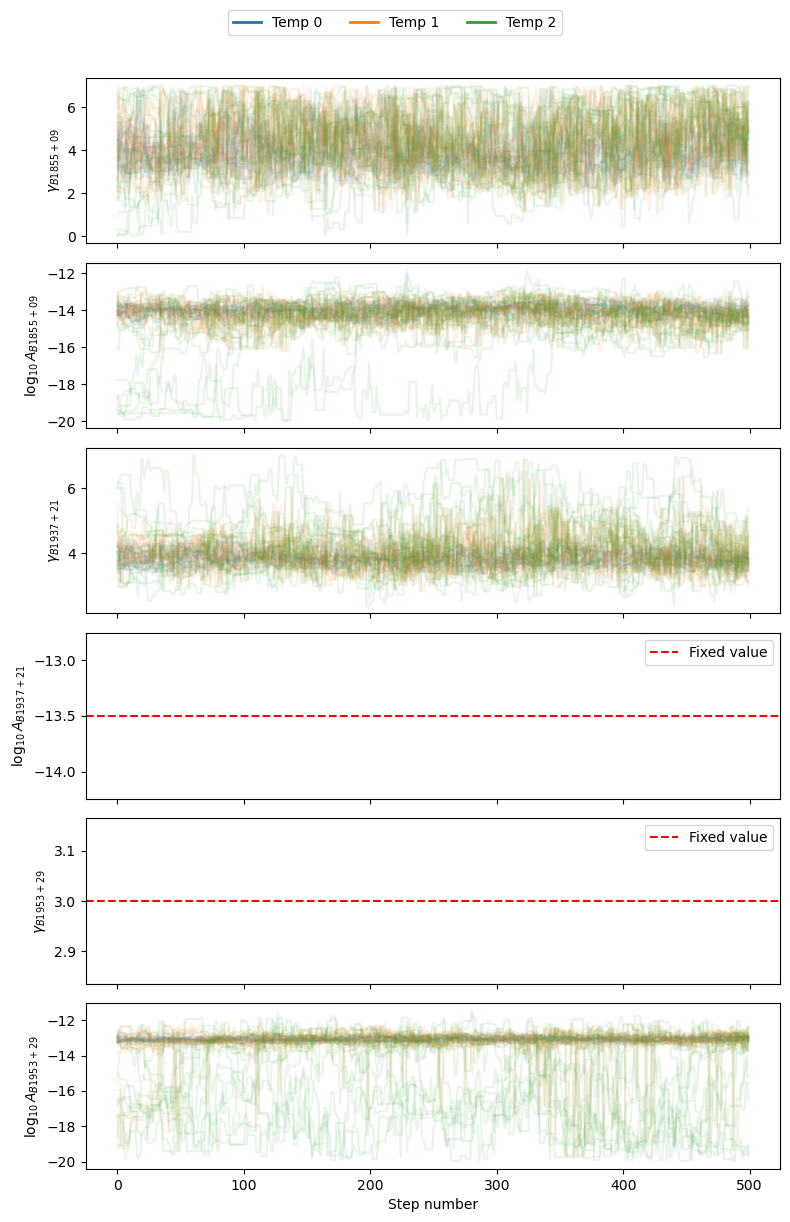

In [14]:
fig = bridge.plot_trace(plot_fixed=True)
fig.show()

Similarly, we can also plot the corner plot of the sampled parameters using the built-in plotting function. Again, this function plots the samples for each temperature separately, so you will see 3 contours for each pair of parameters in our case since we used 3 temperatures.

/var/folders/6y/nrh4dqv10xxc55k_v95rl4l00000gn/T/ipykernel_10068/3008604745.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


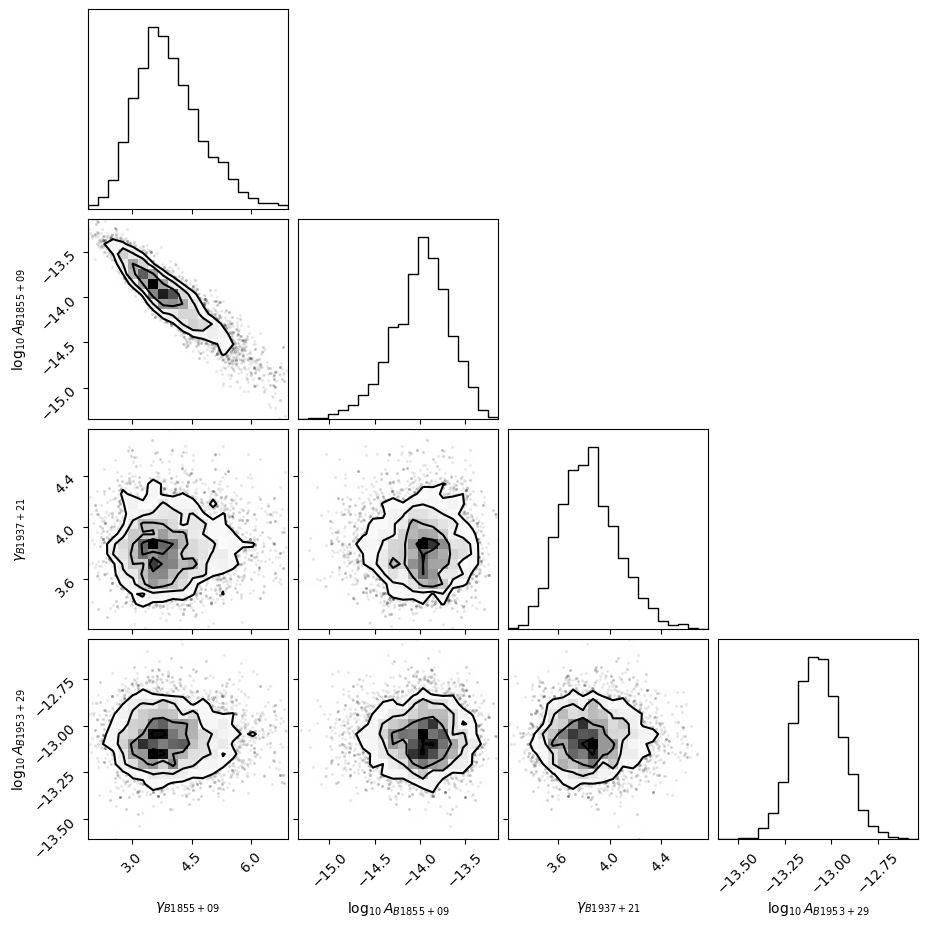

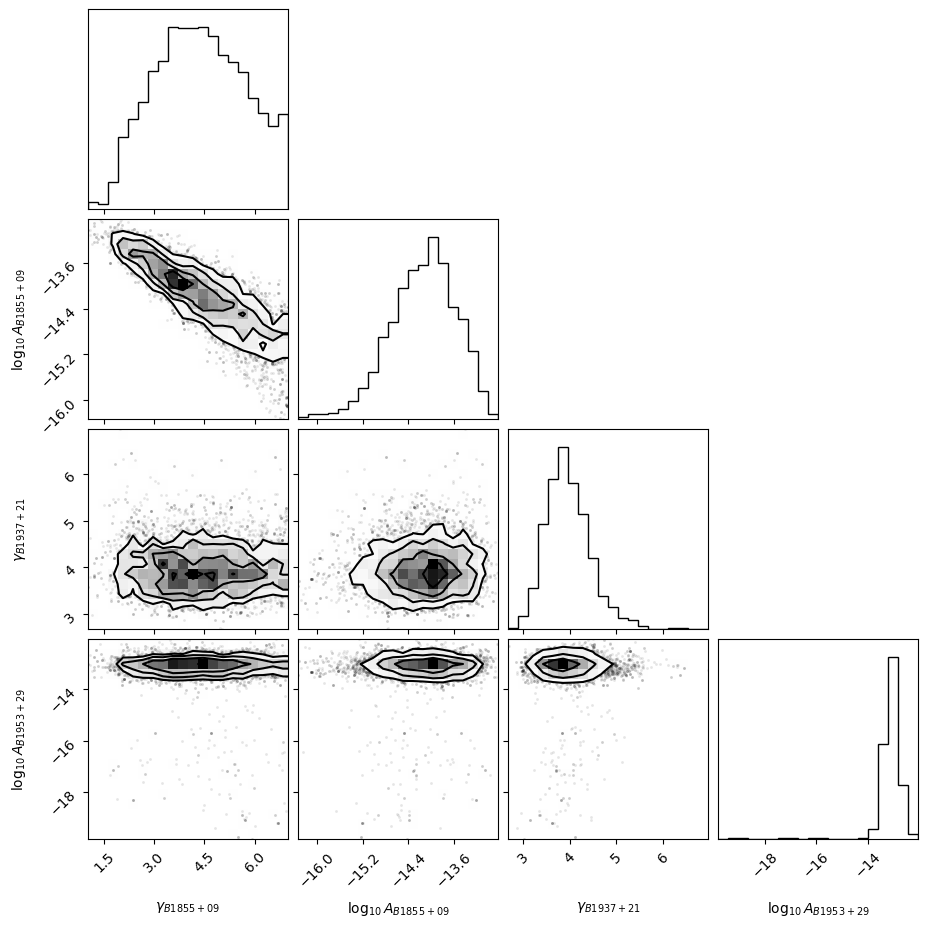

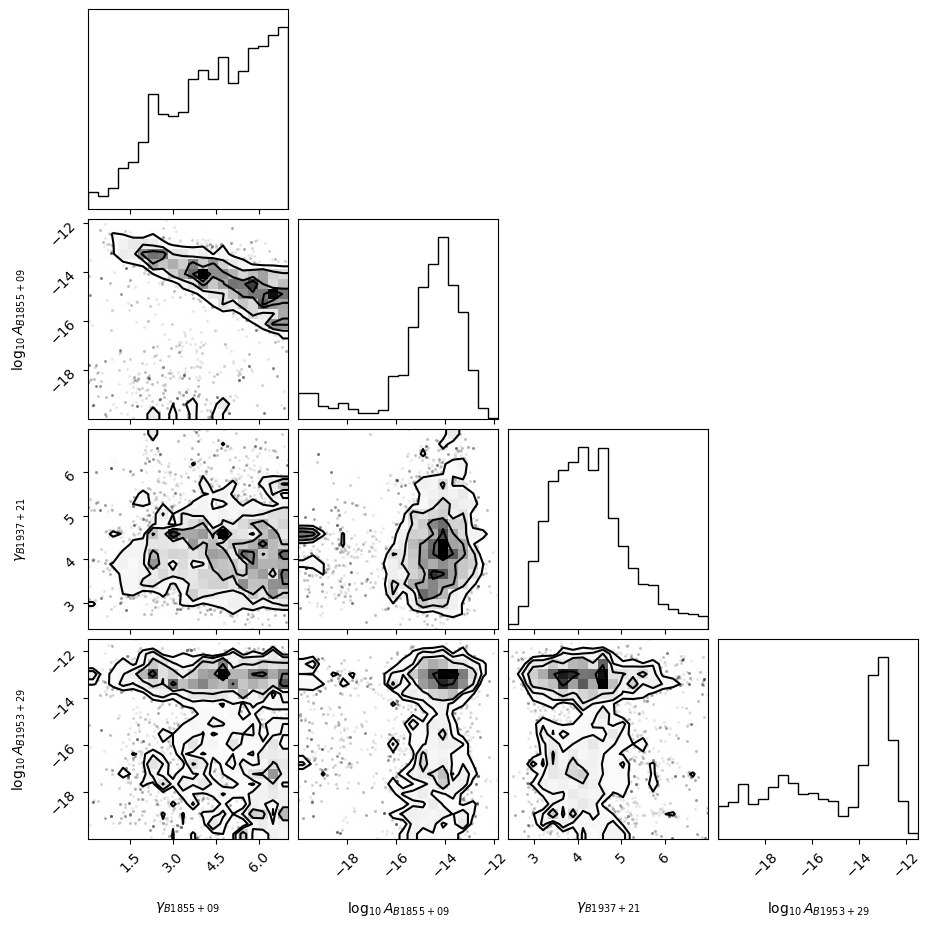

In [15]:
fig2 = bridge.plot_corner()
for fig in fig2:
    fig.show()